In [1]:
"""
Author: LiGorden
Email: likehao1006@gmail.com

Check the performance of model
"""
import os
import gc
import random
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms, datasets

import numpy as np
from sklearn.metrics import roc_auc_score
import shap
from PIL import Image
import matplotlib.pyplot as plt

### Result of using mfp mpa data, split train/val by sample within sample 374. Test data is out of scope of sample 374. 
### train:val:test = 265:49:278 = 45:8:47
### This serve as a baseline analysis

In [2]:
# ----------------------For directly calculate accurate for ViT 16----------------------
root_result_ViT_16 = os.path.abspath(os.path.join(os.getcwd(), "..", "result", "model_trained", "ViT", "no_lr"))
result_ViT_16_train_loss = np.load(os.path.join(root_result_ViT_16, "train_loss.npy"))
result_ViT_16_val_loss = np.load(os.path.join(root_result_ViT_16, "val_loss.npy"))

result_ViT_16_train_loss_ckpt = list()
result_ViT_16_val_loss_ckpt = list()
result_ViT_16_test_loss_ckpt = list()
result_file = ["ckpt_1", "ckpt_10", "ckpt_20",
               "ckpt_30", "ckpt_40", "ckpt_50",
               "ckpt_60", "ckpt_70", "ckpt_80",
               "ckpt_90", "ckpt_100", "ckpt_110",
               "ckpt_120", "ckpt_130", "ckpt_140",
               "ckpt_150"]

for file in result_file:
    result_ViT_16_train_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "train_loss.npy")).item())
    result_ViT_16_val_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "val_loss.npy")).item())
    result_ViT_16_test_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "test_loss.npy")).item())

In [3]:
result_ViT_16_pred_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_train_data.npy"))
result_ViT_16_true_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_train_data.npy"))
result_ViT_16_pred_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_val_data.npy"))
result_ViT_16_true_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_val_data.npy"))
result_ViT_16_pred_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_test_data.npy"))
result_ViT_16_true_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_test_data.npy"))

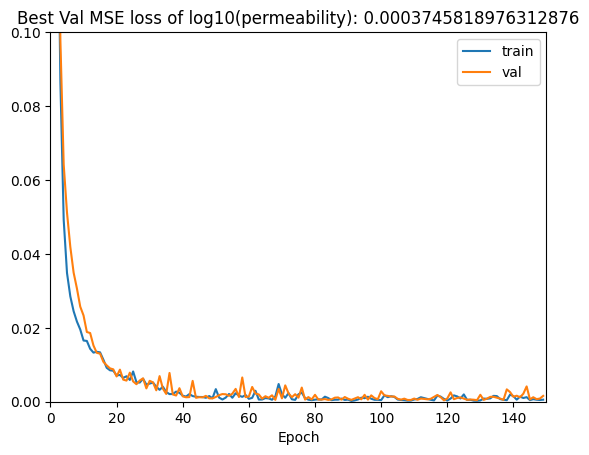

In [4]:
# plot the train/val loss
plt.figure()
plt.title("Best Val MSE loss of log10(permeability): " + str(np.min(result_ViT_16_val_loss)))
plt.xlabel("Epoch")
plt.xlim((0, 150))
plt.ylim((0, 0.1))
plt.plot(result_ViT_16_train_loss, label="train")
plt.plot(result_ViT_16_val_loss, label="val")
plt.legend()

Text(0.5, 0, 'Epoch')

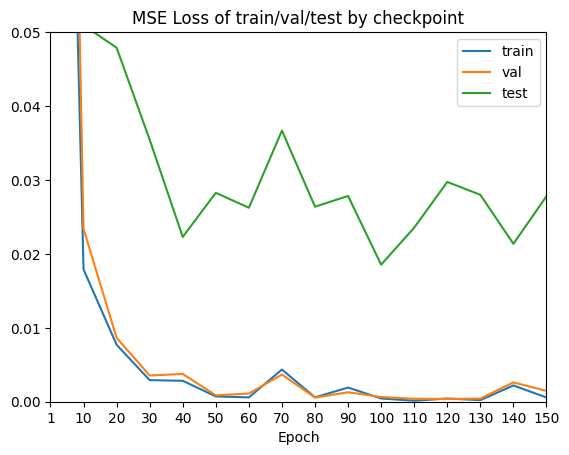

In [5]:
plt.figure()
plt.ylim((0, 0.05))
plt.xlim((0, 15))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ["1", "10", "20", "30", "40", "50", "60", 
                                                                    "70", "80", "90", "100", "110", "120", 
                                                                    "130", "140", "150"])
plt.title("MSE Loss of train/val/test by checkpoint")
plt.plot(result_ViT_16_train_loss_ckpt, label="train")
plt.plot(result_ViT_16_val_loss_ckpt, label="val")
plt.plot(result_ViT_16_test_loss_ckpt, label="test")
plt.legend()
plt.xlabel("Epoch")

{'whiskers': [<matplotlib.lines.Line2D at 0x235f293ff10>,
 'caps': [<matplotlib.lines.Line2D at 0x235f294d490>,
 'boxes': [<matplotlib.lines.Line2D at 0x235f293fc70>],
 'medians': [<matplotlib.lines.Line2D at 0x235f294da00>],
 'fliers': [<matplotlib.lines.Line2D at 0x235f294dcd0>],
 'means': []}

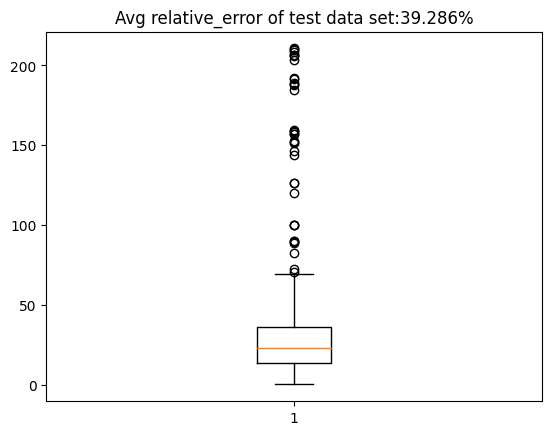

In [6]:
# check the boxplot of relative error
relative_error = abs((10 ** result_ViT_16_pred_test - 10 ** result_ViT_16_true_test) / (10 ** result_ViT_16_true_test) * 100)
plt.title("Avg relative_error of test data set:" + str(round(np.mean(relative_error), 3)) + "%")
plt.boxplot(relative_error)

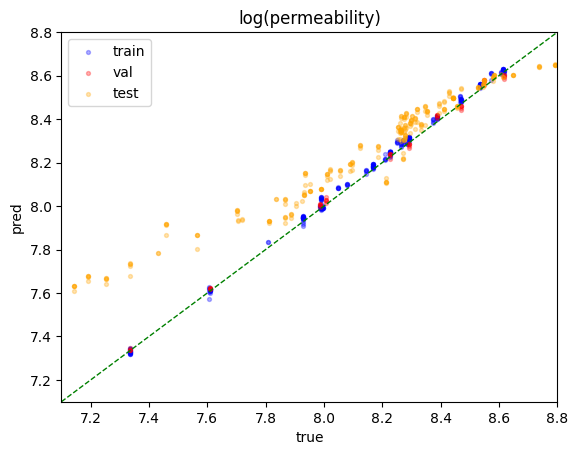

In [7]:
# plot the true value and pred value
x = np.linspace(7.1, 8.8, 50)
y = x

plt.figure()
plt.title("log(permeability)")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(7.1, 8.8)
plt.ylim(7.1, 8.8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(result_ViT_16_true_train, result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(result_ViT_16_true_val, result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(result_ViT_16_true_test, result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")

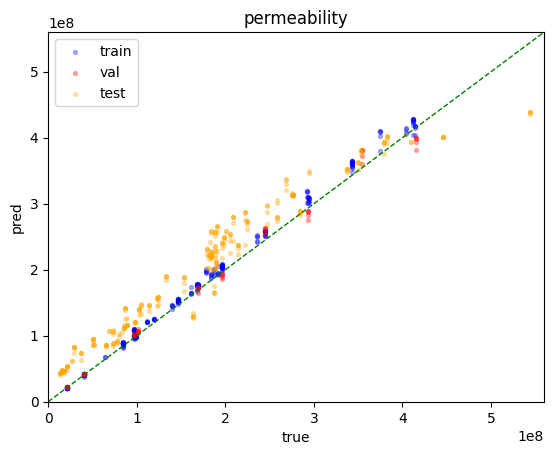

In [8]:
# plot the true value and pred value
x = np.linspace(0, 5.6 * 10 ** 8, 50)
y = x

plt.figure()
plt.title("permeability")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(0, 5.6 * 10 ** 8)
plt.ylim(0, 5.6 * 10 ** 8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(10 ** result_ViT_16_true_train, 10 ** result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(10 ** result_ViT_16_true_val, 10 ** result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(10 ** result_ViT_16_true_test, 10 ** result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")

### Result of using mfp mpa data, split train/val by sample within sample 374. Test data is out of scope of sample 374. 
### train:val:test = 265:49:278 = 45:8:47
### It is the baseline model + lr_schedular

In [9]:
# ----------------------For directly calculate accurate for ViT 16----------------------
root_result_ViT_16 = os.path.abspath(os.path.join(os.getcwd(), "..", "result", "model_trained", "ViT"))
result_ViT_16_train_loss = np.load(os.path.join(root_result_ViT_16, "train_loss.npy"))
result_ViT_16_val_loss = np.load(os.path.join(root_result_ViT_16, "val_loss.npy"))

result_ViT_16_train_loss_ckpt = list()
result_ViT_16_val_loss_ckpt = list()
result_ViT_16_test_loss_ckpt = list()
result_file = ["ckpt_15", "ckpt_30", "ckpt_45",
               "ckpt_60", "ckpt_75", "ckpt_90", 
               "ckpt_105", "ckpt_120", "ckpt_135", "ckpt_150"]

for file in result_file:
    result_ViT_16_train_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "train_loss.npy")).item())
    result_ViT_16_val_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "val_loss.npy")).item())
    result_ViT_16_test_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "test_loss.npy")).item())

In [10]:
result_ViT_16_pred_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_train_data.npy"))
result_ViT_16_true_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_train_data.npy"))
result_ViT_16_pred_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_val_data.npy"))
result_ViT_16_true_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_val_data.npy"))
result_ViT_16_pred_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_test_data.npy"))
result_ViT_16_true_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_test_data.npy"))

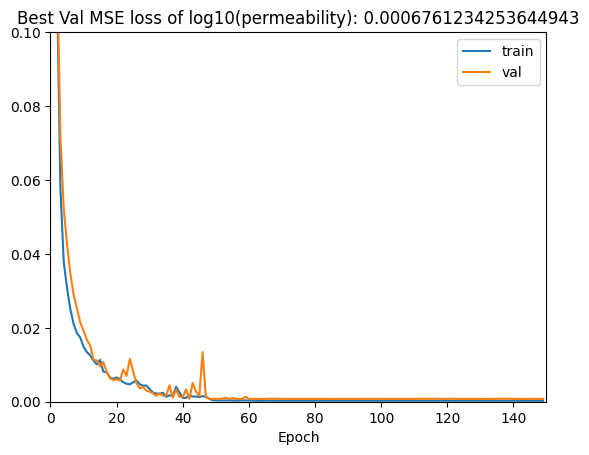

In [11]:
# plot the train/val loss
plt.figure()
plt.title("Best Val MSE loss of log10(permeability): " + str(np.min(result_ViT_16_val_loss)))
plt.xlabel("Epoch")
plt.xlim((0, 150))
plt.ylim((0, 0.1))
plt.plot(result_ViT_16_train_loss, label="train")
plt.plot(result_ViT_16_val_loss, label="val")
plt.legend()

Text(0.5, 0, 'Epoch')

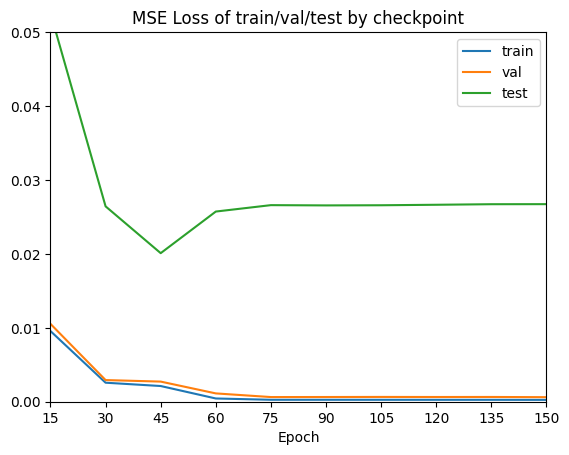

In [12]:
plt.figure()
plt.ylim((0, 0.05))
plt.xlim((0, 9))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ["15", "30", "45", "60", 
                                            "75", "90", "105", "120", 
                                             "135", "150"])
plt.title("MSE Loss of train/val/test by checkpoint")
plt.plot(result_ViT_16_train_loss_ckpt, label="train")
plt.plot(result_ViT_16_val_loss_ckpt, label="val")
plt.plot(result_ViT_16_test_loss_ckpt, label="test")
plt.legend()
plt.xlabel("Epoch")

{'whiskers': [<matplotlib.lines.Line2D at 0x235f2dbc850>,
 'caps': [<matplotlib.lines.Line2D at 0x235f2dbcd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x235f2dbc5b0>],
 'medians': [<matplotlib.lines.Line2D at 0x235f2dca280>],
 'fliers': [<matplotlib.lines.Line2D at 0x235f2dca520>],
 'means': []}

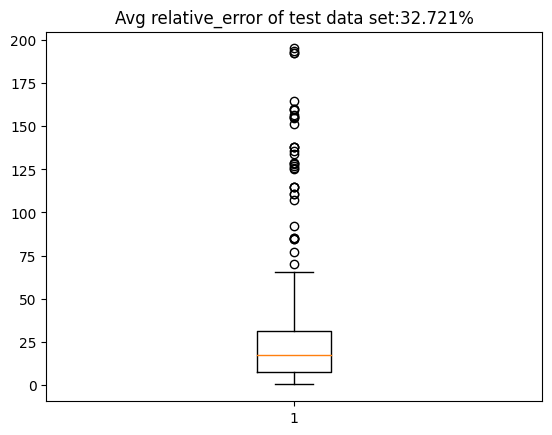

In [13]:
# check the boxplot of relative error
relative_error = abs((10 ** result_ViT_16_pred_test - 10 ** result_ViT_16_true_test) / (10 ** result_ViT_16_true_test) * 100)
plt.title("Avg relative_error of test data set:" + str(round(np.mean(relative_error), 3)) + "%")
plt.boxplot(relative_error)

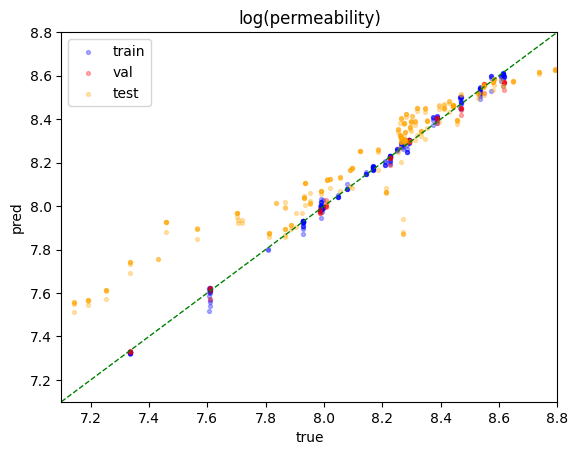

In [14]:
# plot the true value and pred value
x = np.linspace(7.1, 8.8, 50)
y = x

plt.figure()
plt.title("log(permeability)")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(7.1, 8.8)
plt.ylim(7.1, 8.8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(result_ViT_16_true_train, result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(result_ViT_16_true_val, result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(result_ViT_16_true_test, result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")

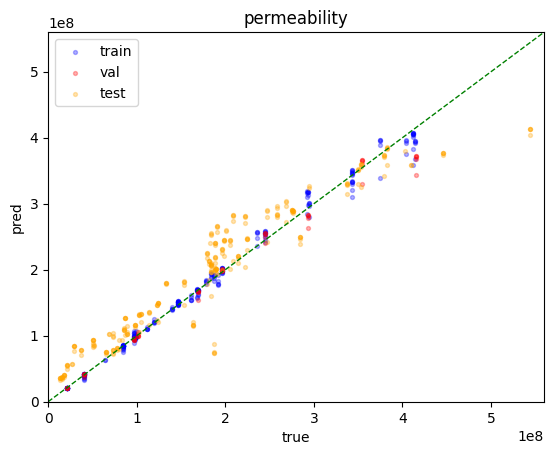

In [16]:
# plot the true value and pred value
x = np.linspace(0, 5.6 * 10 ** 8, 50)
y = x

plt.figure()
plt.title("permeability")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(0, 5.6 * 10 ** 8)
plt.ylim(0, 5.6 * 10 ** 8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(10 ** result_ViT_16_true_train, 10 ** result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(10 ** result_ViT_16_true_val, 10 ** result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(10 ** result_ViT_16_true_test, 10 ** result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")

### Result of using mfp mpa data and elec Iz data, split train/val by sample within sample 374. Test data out of sample 374. 
### train:val:test = 265:49:278 = 45:8:47. 
### Concat MPa & elec channel wise

In [17]:
# ----------------------For directly calculate accurate for ViT 16----------------------
root_result_ViT_16 = os.path.abspath(os.path.join(os.getcwd(), "..", "result", "model_trained", "ViT_concat_by_channel"))
result_ViT_16_train_loss = np.load(os.path.join(root_result_ViT_16, "train_loss.npy"))
result_ViT_16_val_loss = np.load(os.path.join(root_result_ViT_16, "val_loss.npy"))

result_ViT_16_train_loss_ckpt = list()
result_ViT_16_val_loss_ckpt = list()
result_ViT_16_test_loss_ckpt = list()
result_file = ["ckpt_15", "ckpt_30", "ckpt_45", "ckpt_60", "ckpt_75", "ckpt_90", "ckpt_105", "ckpt_120", "ckpt_135", "ckpt_150"]
for file in result_file:
    result_ViT_16_train_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "train_loss.npy")).item())
    result_ViT_16_val_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "val_loss.npy")).item())
    result_ViT_16_test_loss_ckpt.append(np.load(os.path.join(root_result_ViT_16, file, "test_loss.npy")).item())

In [18]:
result_ViT_16_pred_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_train_data.npy"))
result_ViT_16_true_train = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_train_data.npy"))
result_ViT_16_pred_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_val_data.npy"))
result_ViT_16_true_val = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_val_data.npy"))
result_ViT_16_pred_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "pred_test_data.npy"))
result_ViT_16_true_test = np.load(os.path.join(root_result_ViT_16, "ckpt_best", "true_test_data.npy"))

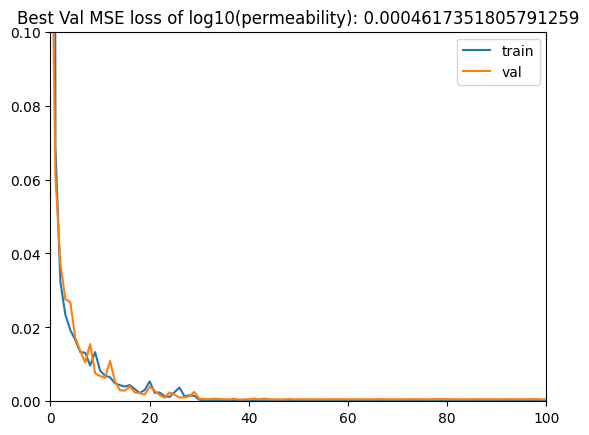

In [19]:
# plot the train/val loss
plt.figure()
plt.title("Best Val MSE loss of log10(permeability): " + str(np.min(result_ViT_16_val_loss)))
plt.xlim((0, 100))
plt.ylim((0, 0.1))
plt.plot(result_ViT_16_train_loss, label="train")
plt.plot(result_ViT_16_val_loss, label="val")
plt.legend()

Text(0.5, 0, 'Epoch')

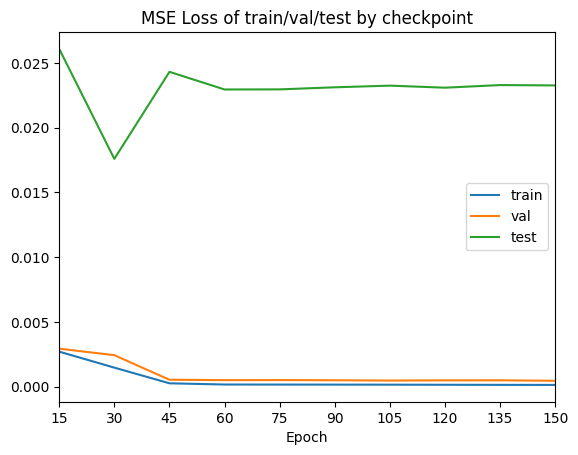

In [20]:
plt.figure()
plt.xlim((0, 9))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ["15", "30", "45", "60", "75", "90", "105", "120", "135", "150"])
plt.title("MSE Loss of train/val/test by checkpoint")
plt.plot(result_ViT_16_train_loss_ckpt, label="train")
plt.plot(result_ViT_16_val_loss_ckpt, label="val")
plt.plot(result_ViT_16_test_loss_ckpt, label="test")
plt.legend()
plt.xlabel("Epoch")

{'whiskers': [<matplotlib.lines.Line2D at 0x235f2c98430>,
 'caps': [<matplotlib.lines.Line2D at 0x235f28af250>,
 'boxes': [<matplotlib.lines.Line2D at 0x235f289ba00>],
 'medians': [<matplotlib.lines.Line2D at 0x235f28b3820>],
 'fliers': [<matplotlib.lines.Line2D at 0x235f28b3f40>],
 'means': []}

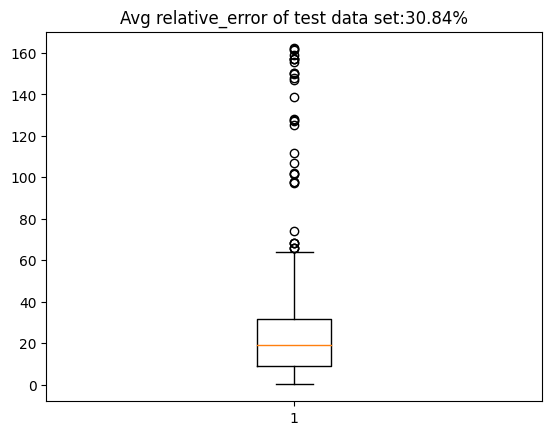

In [21]:
# check the boxplot of relative error
relative_error = abs((10 ** result_ViT_16_pred_test - 10 ** result_ViT_16_true_test) / (10 ** result_ViT_16_true_test) * 100)
plt.title("Avg relative_error of test data set:" + str(round(np.mean(relative_error), 3)) + "%")
plt.boxplot(relative_error)

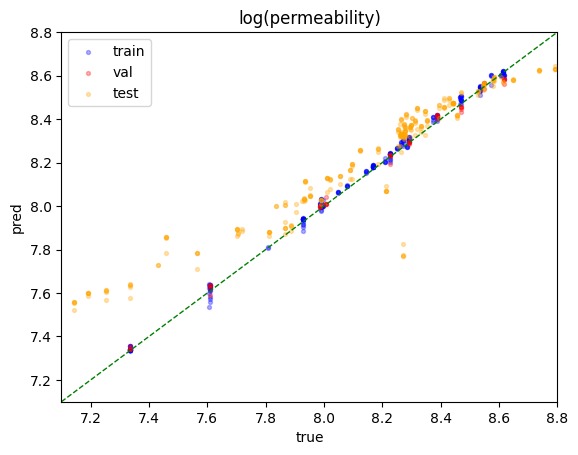

In [22]:
# plot the true value and pred value
x = np.linspace(7.1, 8.8, 50)
y = x

plt.figure()
plt.title("log(permeability)")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(7.1, 8.8)
plt.ylim(7.1, 8.8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(result_ViT_16_true_train, result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(result_ViT_16_true_val, result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(result_ViT_16_true_test, result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")

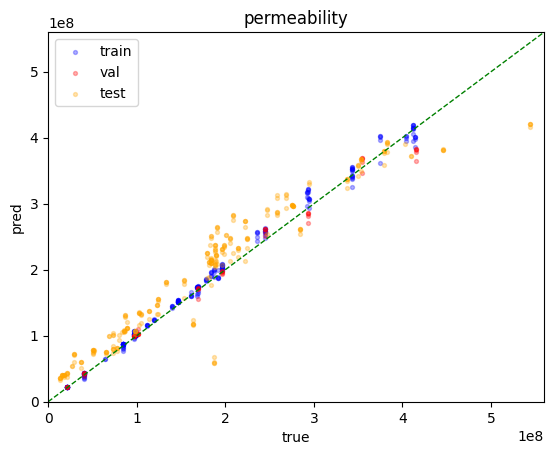

In [23]:
# plot the true value and pred value
x = np.linspace(0, 5.6 * 10 ** 8, 50)
y = x

plt.figure()
plt.title("permeability")
plt.xlabel("true")
plt.ylabel("pred")
plt.xlim(0, 5.6 * 10 ** 8)
plt.ylim(0, 5.6 * 10 ** 8)
plt.plot(x, y, color='green', linewidth=1.0, linestyle='--')
train_plt = plt.scatter(10 ** result_ViT_16_true_train, 10 ** result_ViT_16_pred_train, color='blue', alpha = 0.3, s=8)
val_plt = plt.scatter(10 ** result_ViT_16_true_val, 10 ** result_ViT_16_pred_val, color='red', alpha = 0.3, s=8)
test_plt = plt.scatter(10 ** result_ViT_16_true_test, 10 ** result_ViT_16_pred_test, color='orange', alpha = 0.3, s=8)
plt.legend((train_plt, val_plt, test_plt), ("train", "val", "test"), loc="best")